## Problem Setting & Algorithm
### Introduction
Stochastic Gradient Descent (SGD) is a approach to solving linear classification problems such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

The advantages of Stochastic Gradient Descent are:
Efficiency,
Ease of implementation (lots of opportunities for code tuning).
The disadvantages of Stochastic Gradient Descent include:
SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations,
SGD is sensitive to feature scaling.

### Problem Setting
Given a set of training examples $(x_1,y_1),\cdots,(x_n,y_n)$ where $x_i\in R^m$ and $y_i\in{-1,1}$, the goal is to learn a linear scoring function $f(x)=w^Tx+b$ with model parameters $w\in R^m$ and intercept $b\in R$. In order to make predictions, we simply look at the sign of $f(x)$. The regularized training error, which is the number stochastic gradient descent actually tries to minimize, is 
\begin{align*}
E(w,b)&=\frac{1}{n}\sum_{i=1}^n L(y_i,f(x_i))+\alpha R(w)
\end{align*}
where $L$ is a loss function and R is a penalty term for model complexity; $\alpha>0$ is a non-negative parameter. Different choices for L entail different classifiers such as
Hinge: (soft-margin) Support Vector Machines, Log: Logistic Regression, Least-Squares: Ridge Regression, Epsilon-Insensitive: (soft-margin) Support Vector Regression. All of the above loss functions can be regarded as an upper bound on the misclassification error (Zero-one loss). The choices for regularization terms include: L2 normm $R(w):=\frac{1}{2}\sum w_i^2$, L1 norm $R(w):=\sum |w_i|$, and elastic net $R(w):=\frac{\rho}{2}\sum w_i^2+(1-\rho)\sum|w_i|$.

### The Stochastic Gradient Descent Algorithm
The SGD algorithm takes an initial weight vector $w$ and intercept $b$. At each time step of the SGD algorithm, $w$ and $b$ are updated using data from a single sample
\begin{align*}
w&\leftarrow w-\eta_t(\alpha\frac{\partial R(w)}{\partial w}+\frac{\partial L(w^Tx_i+b,y_i)}{\partial w})\\
b&\leftarrow b-\eta_t(\frac{\partial L(w^Tx_i+b,y_i)}{\partial b})
\end{align*}
The algorithm runs through the data set one-sample at a time until the it runs through the whole dataset, and repeats the process. SGD terminates after a fixed number of iterations through the dataset. Theoretically, the algorithm is guaranteed to converge if $\eta_t$ satisfies the Robbins-Monro conditions
\begin{align*}
\sum_{t=1}^\infty \eta_t =\infty, \sum_{t=1}^\infty \eta_t^2 <\infty
\end{align*}
Letting the algorithm run for more iterations generally means a higher chance of convergence, but this is not guaranteed. A common practice is to shuffle the data samples after each run through the entire data. 

In this paper we will assume a Hinge loss function, a L2 norm regularization term and 
\begin{align*}
\eta_t&=\frac{1}{\alpha(t_0+t)}
\end{align*}
for Scikit learn $t_0$ is based on a heuristic proposed by Leon Bottou. This becomes the normal SVM problem. 

### Intuition through an example
We a dataset of 400 samples, each sample has a two dimensional X variable and the class variable Y which takes values -1 and 1. The scatterplot of these data is as follows

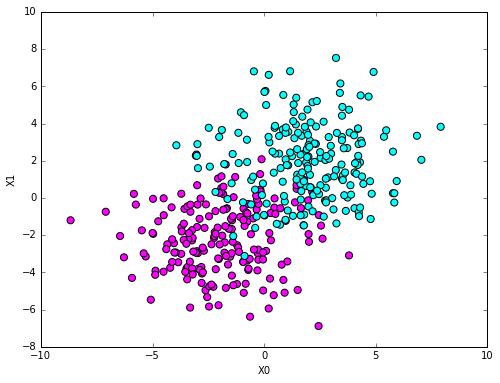

In [5]:
from numpy import loadtxt
train = loadtxt('data_stdev2_train.csv')
X = train[:,0:2]
Y = train[:,2:3]
import pylab as pl
%matplotlib inline
pl.figure(0,figsize=(8, 6))
pl.ylabel('X1')
pl.xlabel('X0')
pl.scatter(X[:, 0], X[:, 1], c=(1.-Y), s=50, cmap = pl.cm.cool)

The purpose of SVM is to find a weight vector $w$ and intercept $b$ such that the line described by $w_0X_1+w_0X_2+b=0$ best separates the two classes of points. Stochastic gradient descent will obtain the optimal $w$ and $b$ from the data. 

## Implementation in Python

In [1]:
class Lossfunction:
    def loss(self, p, y):
        return 0
    def dloss(self, p, y):
        return 0

In [2]:
class Hinge(Lossfunction):
    def __init__(self, threshold=1):
        self.threshold=threshold
    def loss(self, p, y):
        z=p*y
        
        if z<=self.threshold:
            return (self.threshold-z)
        return 0
    def _dloss(self, p ,y):
        z= p*y
        if z<=self.threshold:
            return -y
        return 0

In [3]:
import numpy as np
class sgddata:
    def __init__(self, X, Y, sample_weights=0,seed=None):
        if len(X)!=len(Y):
            raise IndexError('X, Y not same length')
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.sample_weights = sample_weights
        self.n_samples = self.X.shape[0]
        self.n_features = self.X.shape[1]
        self.current_index = -1
    def __next__(self):
        self.current_index += 1
        return self.X[self.current_index], self.Y[self.current_index]
    def _reset(self):
        self.current_index = -1
    def shuffle(self ,seed=None):
        np.random.seed(seed)
        idx = np.random.permutation(self.n_samples)
        self.X = self.X[idx]
        self.Y = self.Y[idx]
    def __str__(self):
        return '{},{}'.format(str(self.X), str(self.Y))

In [4]:
from time import time
def sgd( weights,
               intercept,
               loss,
               penalty_type,
               alpha,  
               dataset,
               n_iter, fit_intercept=True,
               verbose=False, shuffle=True, seed=None,
               weight_pos=1, weight_neg=1,
               eta0=0,
               t=1.0,
               intercept_decay=1.0):
    MAX_DLOSS = 1e12
    eta = eta0
    l1_ratio = 0.0
    sumlosslist = []
    n_samples=dataset.n_samples
    typw = np.sqrt(1.0 / np.sqrt(alpha))
    # computing eta0, the initial learning rate
    initial_eta0 = typw / max(1.0, loss.dloss(-typw, 1.0))
    # initialize t such that eta at first sample equals eta0
    optimal_init = 1.0 / (initial_eta0 * alpha)
    t_start = time()
    for epoch in range(n_iter):
        sumloss=0

        if shuffle:
            dataset.shuffle(seed)
        for i in range(n_samples):
            x_current,y_current = next(dataset)
            p = np.dot(x_current,weights) + intercept
            eta = 1.0 / (alpha * (optimal_init + t - 1))
            if y_current > 0.0:
                class_weight = weight_pos
            else:
                class_weight = weight_neg
            dloss = loss._dloss(p, y_current)
            # clip dloss with large values to avoid numerical
            # instabilities
            if dloss < -MAX_DLOSS:
                dloss = -MAX_DLOSS
            elif dloss > MAX_DLOSS:
                dloss = MAX_DLOSS
            update = -eta * dloss
            update *= class_weight
            weights *= (max(0, 1.0 - ((1.0 - l1_ratio) * eta * alpha)))
            if update != 0.0:
                weights += update*x_current
                if fit_intercept == 1:
                    intercept += update * intercept_decay
            dataset._reset()
            t += 1
        if verbose > 0:
            sumloss=0
            for i in range(n_samples):
                x_current,y_current = next(dataset)
                p = np.dot(x_current,weights) + intercept
                sumloss+=loss.loss(p,y_current)
#             print("loss={}".format(str(sumloss)))
            sumlosslist.append(sumloss)
            dataset._reset()
    print('time = {} second'.format(str(time()-t_start)))
    return weights, intercept,sumlosslist

## Running with Data
We use the initial weight $[0,0]$ and initial intercept $0$ to initialize the SGD. We let $\alpha=0.01$ and run the algorithm through 1000 iterations through the data. 

time = 12.75475263595581 second


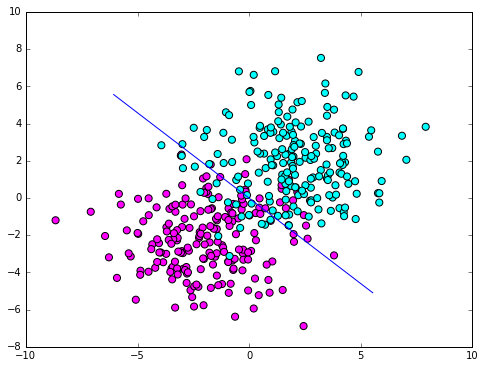

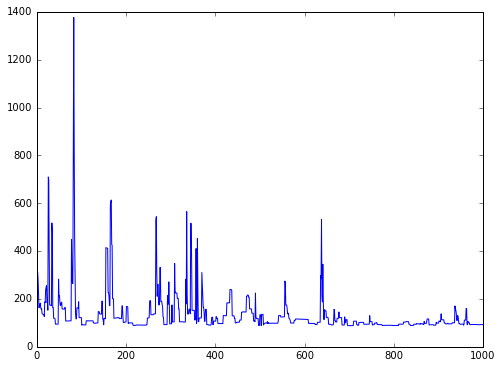

In [6]:
weight_init=np.array([0.,0.])
intercept_init = 0.
dataset = sgddata(X,Y)
loss=Hinge()
n_iter = 1000
verbose=True
weights,intercept,sumlosslist=sgd(weight_init,intercept_init,loss,'L2',0.01,dataset,n_iter,verbose=verbose)
import pylab as pl
%matplotlib inline
pl.figure(0,figsize=(8, 6))
pl.scatter(X[:, 0], X[:, 1], c=(1.-Y), s=50, cmap = pl.cm.cool)
x1 = np.linspace(min(X[:, 0])*0.7,max(X[:, 0])*0.7,10)
x2 = -(weights[0]*x1+intercept)/weights[1]
pl.plot(x1,x2)
if verbose:
    pl.figure(1,figsize=(8, 6))
    pl.plot(range(n_iter),sumlosslist)

We see from the top figure that the SGD algorithm arrived a reasonable conclusion. Our bottom plot shows the stochastic nature of the process of convergence. Setting $\alpha$ to a smaller value increases the step size and leads to higher fluctuations. 

## Scikit Learn Optimizations
Scikit learn optimizes SGD using Cython. The optimizations mostly happen in three areas: 1. The loss function, 2. The data structure that stores the data, 3. The datastructure that stores and updates the weight vector and 4. The implementation of SGD itself. Throughout the Cython implementation, functions and variables are statically typed whenever possible. This ensures that the costs associated with Python dynamic typing are minimized.  

### Optimizations in Loss Function
The hinge loss function is implemented in Cython at lines <a href="https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/linear_model/sgd_fast.pyx#L138-L167">138-167</a>, copied below. Besides the __init__ function that initialize the Hinge object, all other functions and all variables are statically typed. 

In [ ]:
cdef class Hinge(Classification):
    """Hinge loss for binary classification tasks with y in {-1,1}
    Parameters
    ----------
    threshold : float > 0.0
        Margin threshold. When threshold=1.0, one gets the loss used by SVM.
        When threshold=0.0, one gets the loss used by the Perceptron.
    """

    cdef double threshold

    def __init__(self, double threshold=1.0):
        self.threshold = threshold

    cdef double loss(self, double p, double y) nogil:
        cdef double z = p * y
        if z <= self.threshold:
            return (self.threshold - z)
        return 0.0

    cdef double _dloss(self, double p, double y) nogil:
        cdef double z = p * y
        if z <= self.threshold:
            return -y
        return 0.0

    def __reduce__(self):
        return Hinge, (self.threshold,)

### Optimizations in Data Storage
Scikit-learn first convert the data into a ArrayDataset object, which is also implemented in Cython. The code that converts the raw input data to a ArrayDataset is linked <a href="https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/linear_model/base.py#L48-L67">here</a>.  

First, we look at how ArrayDataSet is initialized. At lines <a href="https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/seq_dataset.pyx#L195-L196">195-196</a> we see that ArrayDataSet creates memoryviews to the numpy array X and Y and assign their pointers to X_data_ptr and Y_data_ptr.  

In [ ]:
self.X_data_ptr = <double *>X.data
self.Y_data_ptr = <double *>Y.data

The SGD algorithm goes through the dataset samples one-by-one. This is called in the SGD algorithm at lines <a href="https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/linear_model/sgd_fast.pyx#L606-L607">606-607</a>, copied below. We see that this is implemented within the ArrayDataSet object

In [ ]:
dataset.next(&x_data_ptr, &x_ind_ptr, &xnnz,
                             &y, &sample_weight)

We take a closer look at the .next() function. The .next function is implemented at lines <a href="https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/seq_dataset.pyx#L20-L46">20-46</a> of seq_dataset.pyx. The ArrayDataSet object keeps a data index, which .next() calls, advancing the index by one, and then calls the <a href="https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/seq_dataset.pyx#L207-L217">._sample</a> function,

In [ ]:
cdef void _sample(self, double **x_data_ptr, int **x_ind_ptr,
                      int *nnz, double *y, double *sample_weight,
                      int current_index) nogil:
        cdef long long sample_idx = self.index_data_ptr[current_index]
        cdef long long offset = sample_idx * self.X_stride

        y[0] = self.Y_data_ptr[sample_idx]
        x_data_ptr[0] = self.X_data_ptr + offset
        x_ind_ptr[0] = self.feature_indices_ptr
        nnz[0] = self.n_features
        sample_weight[0] = self.sample_weight_data[sample_idx]

We see that the _sample function takes x_data_ptr and y and make it so they point to the pointer to the start of $X_i$. x_data_ptr and y are then used by the rest of the SGD algorithm to access the current sample. The main optimizations in this data storage step, aside from static typing, are the usage of memoryviews and the usage of pointer to access data. Memoryviews allows sharing memory between data structures without copying, while data access through pointers is much faster than a Python function such as the getitem command.

### Optimizations in Weights

The weight vector is stored in a WeightVector object at line <a href="https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/linear_model/sgd_fast.pyx#L551">551</a> in sgd_fast.pyx

In [ ]:
cdef WeightVector w = WeightVector(weights, average_weights)

The WeightVector object is defined <a href="https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/weight_vector.pyx">here</a>. Its mechanism of data storage is similar to ArrayDataset, relevant lines below

In [ ]:
cdef double *wdata = <double *>w.data

        if w.shape[0] > INT_MAX:
            raise ValueError("More than %d features not supported; got %d."
                             % (INT_MAX, w.shape[0]))
        self.w = w
        self.w_data_ptr = wdata

All operations that update the weight vector is done within the WeightVector object. In particular we look at the <a href="https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/weight_vector.pyx#L71-L105"> add function</a>, which scales sample x by constant c and add it to the weight vector. SGD calls it byWe copy the add function below

In [ ]:
cdef void add(self, double *x_data_ptr, int *x_ind_ptr, int xnnz,
                  double c) nogil:
        """Scales sample x by constant c and adds it to the weight vector.
        This operation updates ``sq_norm``.
        Parameters
        ----------
        x_data_ptr : double*
            The array which holds the feature values of ``x``.
        x_ind_ptr : np.intc*
            The array which holds the feature indices of ``x``.
        xnnz : int
            The number of non-zero features of ``x``.
        c : double
            The scaling constant for the example.
        """
        cdef int j
        cdef int idx
        cdef double val
        cdef double innerprod = 0.0
        cdef double xsqnorm = 0.0

        # the next two lines save a factor of 2!
        cdef double wscale = self.wscale
        cdef double* w_data_ptr = self.w_data_ptr

        for j in range(xnnz):
            idx = x_ind_ptr[j]
            val = x_data_ptr[j]
            innerprod += (w_data_ptr[idx] * val)
            xsqnorm += (val * val)
            w_data_ptr[idx] += val * (c / wscale)

        self.sq_norm += (xsqnorm * c * c) + (2.0 * innerprod * wscale * c)

Getting values from $X_i$ is done using x_data_ptr[j], modifying the weight vector is done similarly. The optimizations for this step include ther aforementioned static typing, memoryviews and pointer data access. A further optimization here comes from the "nogil" aregument after the function definition. This releases the global interpreter lock, allowing for higher efficiency through multi-tasking.

### Optimizations in SGD algorithm
The raw code for the SGD algorithm in scikit-learn is <a href="https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/linear_model/sgd_fast.pyx#L529-L700">here</a>. Since we're assuming OPTIMAL learning rate, hinge loss and L2 regularization, we copy the relevant parts of the code below

In [ ]:
def _plain_sgd(np.ndarray[double, ndim=1, mode='c'] weights,
               double intercept,
               np.ndarray[double, ndim=1, mode='c'] average_weights,
               double average_intercept,
               LossFunction loss,
               int penalty_type,
               double alpha, double C,
               double l1_ratio,
               SequentialDataset dataset,
               int n_iter, int fit_intercept,
               int verbose, bint shuffle, np.uint32_t seed,
               double weight_pos, double weight_neg,
               int learning_rate, double eta0,
               double power_t,
               double t=1.0,
               double intercept_decay=1.0,
               int average=0):

    # get the data information into easy vars
    cdef Py_ssize_t n_samples = dataset.n_samples
    cdef Py_ssize_t n_features = weights.shape[0]

    cdef WeightVector w = WeightVector(weights, average_weights)
    cdef double* w_ptr = &weights[0]
    cdef double *x_data_ptr = NULL
    cdef int *x_ind_ptr = NULL
    cdef double* ps_ptr = NULL

    # helper variables
    cdef bint infinity = False
    cdef int xnnz
    cdef double eta = 0.0in
    cdef double p = 0.0
    cdef double update = 0.0
    cdef double sumloss = 0.0
    cdef double y = 0.0
    cdef double sample_weight
    cdef double class_weight = 1.0
    cdef unsigned int count = 0
    cdef unsigned int epoch = 0
    cdef unsigned int i = 0
    cdef int is_hinge = isinstance(loss, Hinge)
    cdef double optimal_init = 0.0
    cdef double dloss = 0.0
    cdef double MAX_DLOSS = 1e12

    # q vector is only used for L1 regularization
    cdef np.ndarray[double, ndim = 1, mode = "c"] q = None
    cdef double * q_data_ptr = NULL

    if penalty_type == L2:
        l1_ratio = 0.0


    if learning_rate == OPTIMAL:
        typw = np.sqrt(1.0 / np.sqrt(alpha))
        # computing eta0, the initial learning rate
        initial_eta0 = typw / max(1.0, loss.dloss(-typw, 1.0))
        # initialize t such that eta at first sample equals eta0a
        optimal_init = 1.0 / (initial_eta0 * alpha)

    t_start = time()
    with nogil:
        for epoch in range(n_iter):
            if verbose > 0:
                with gil:
                    print("-- Epoch %d" % (epoch + 1))
            if shuffle:
                dataset.shuffle(seed)
            for i in range(n_samples):
                dataset.next(&x_data_ptr, &x_ind_ptr, &xnnz,
                             &y, &sample_weight)

                p = w.dot(x_data_ptr, x_ind_ptr, xnnz) + intercept
                if learning_rate == OPTIMAL:
                    eta = 1.0 / (alpha * (optimal_init + t - 1))

                if verbose > 0:
                    sumloss += loss.loss(p, y)

                if y > 0.0:
                    class_weight = weight_pos
                else:
                    class_weight = weight_neg

                
                dloss = loss._dloss(p, y)
                # clip dloss with large values to avoid numerical
                # instabilities
                if dloss < -MAX_DLOSS:
                    dloss = -MAX_DLOSS
                elif dloss > MAX_DLOSS:
                    dloss = MAX_DLOSS
                    
                update = -eta * dloss

                update *= class_weight * sample_weight

                if penalty_type >= L2:
                    # do not scale to negative values when eta or alpha are too
                    # big: instead set the weights to zero
                    w.scale(max(0, 1.0 - ((1.0 - l1_ratio) * eta * alpha)))
                if update != 0.0:
                    w.add(x_data_ptr, x_ind_ptr, xnnz, update)
                    if fit_intercept == 1:
                        intercept += update * intercept_decay


                t += 1
                count += 1

            # report epoch information
            if verbose > 0:
                with gil:
                    print("Norm: %.2f, NNZs: %d, "
                          "Bias: %.6f, T: %d, Avg. loss: %.6f"
                          % (w.norm(), weights.nonzero()[0].shape[0],
                             intercept, count, sumloss / count))
                    print("Total training time: %.2f seconds."
                          % (time() - t_start))

            # floating-point under-/overflow check.
            if (not skl_isfinite(intercept)
                or any_nonfinite(<double *>weights.data, n_features)):
                infinity = True
                break

    if infinity:
        raise ValueError(("Floating-point under-/overflow occurred at epoch"
                          " #%d. Scaling input data with StandardScaler or"
                          " MinMaxScaler might help.") % (epoch + 1))

    w.reset_wscale()

    return weights, intercept, average_weights, average_intercept


Besides the performance benefits from ArrayDataSet and WeightVector, the Cython implementation of SGD itself also benefits from static typing, memoryviews and the release of global interpreter lock. 